<a href="https://colab.research.google.com/github/fleminjohnson/Music-Genre-Identification/blob/main/Music_Genre_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0 -O genres.tar.gz
!tar -xzvf genres.tar.gz

--2025-03-27 05:20:39--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=0 [following]
--2025-03-27 05:20:39--  https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1faf246f2b97bf0759201f9db2.dl.dropboxusercontent.com/cd/0/inline/CmqiHKBguWpKf2XMc-Z77M0QrAtAwWun3r7Fl-DB3sUej2SHr-4wtH7iS0iQz-_nWKqQsA9S5hxEGtttOgmIFxIfm19y87CtQ6ZprMXMXk1SWARCXu_veyKXtjxtwIDg_mo/file# [following]
--2025-03-27 05:20:40--  https://uc1faf246f2b97bf0759201f9db2.dl.dropboxusercontent.com/cd/0/inline/C

In [162]:
import os
import shutil
import random

In [ ]:
!rm /content/genres.tar.gz

In [ ]:
#!rm -rf /content/augmented_genres

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
source_dir = '/content/genres'

In [ ]:
target_dir = '/content/audio_data'

In [ ]:
split_ratios = {
    "train" : 0.8,
    "val"   : 0.1,
    "test"  : 0.1
}

In [ ]:
os.mkdir(target_dir)

In [ ]:
random.seed(42)

In [163]:
def extract_mfcc_sequence(file_path, sr=16000, n_mfcc=40, hop_length=512, segment_duration=2):
    y, _ = librosa.load(file_path, sr=sr)
    segment_samples = segment_duration * sr
    num_segments = int(len(y) / segment_samples)

    mfcc_sequence = []
    for i in range(num_segments):
        start = i * segment_samples
        end = start + segment_samples
        segment = y[start:end]

        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        mfcc_sequence.append(mfcc)  # No flattening here!

    return np.array(mfcc_sequence)  # Shape: (segments, n_mfcc, time_steps)

In [164]:
def prepare_dataset(path, sr=16000, max_segments=15, n_mfcc=40, hop_length=512, segment_duration=2):
    X, y = [], []
    for genre in os.listdir(path):
        genre_dir = os.path.join(path, genre)
        if not os.path.isdir(genre_dir):
            continue

        for file in os.listdir(genre_dir):
            file_path = os.path.join(genre_dir, file)
            mfcc_seq = extract_mfcc_sequence(file_path, sr, n_mfcc, hop_length, segment_duration)

            # Pad or truncate along the segments dimension
            if len(mfcc_seq) < max_segments:
                pad_width = max_segments - len(mfcc_seq)
                mfcc_seq = np.pad(mfcc_seq, ((0, pad_width), (0,0), (0,0)), mode='constant')
            elif len(mfcc_seq) > max_segments:
                mfcc_seq = mfcc_seq[:max_segments]

            X.append(mfcc_seq)
            y.append(genre)

    return np.array(X), np.array(y)

In [165]:
def datagenerator():

  for genre_name in os.listdir(source_dir):
    genre_dir = os.path.join(source_dir,genre_name)

    if not os.path.isdir(genre_dir):
      continue

    all_files = [f for f in os.listdir(genre_dir) if os.path.isfile(os.path.join(genre_dir, f))]

    random.shuffle(all_files)

    total_files = len(all_files)
    train_end = int(total_files * split_ratios['train'])
    val_end = train_end + int(total_files * split_ratios['test'])

    train_files = all_files[:train_end]
    val_files = all_files[train_end:val_end]
    test_files = all_files[val_end:]

    for split_names, file_list in [('train',train_files), ('val',val_files), ('test',test_files)]:
      split_dir = os.path.join(target_dir, split_names, genre_name)
      os.makedirs(split_dir, exist_ok=True)

      for file_name in file_list:
        src_path = os.path.join(genre_dir, file_name)
        dst_path = os.path.join(split_dir, file_name)
        shutil.copyfile(src_path, dst_path)

  print('Data successfully split into train/val/test directories at', target_dir)


In [166]:
import librosa

def extract_mel_spectrogram(file_path, sample_rate=16000, n_fft=2048, hop_length=512, n_mels=128):

  y,sr = librosa.load(file_path, sr=sample_rate)

  mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

  return mel_spectrogram_db

In [167]:
def audio_feature_extraction(root_path, sample_rate=16000, n_fft=2048, hop_length=512, n_mels=128):
    for genre in os.listdir(root_path):
        genre_dir = os.path.join(root_path, genre)
        if not os.path.isdir(genre_dir):
            continue
        for file_name in os.listdir(genre_dir):
            # Rename inner variable to avoid shadowing 'root_path'
            audio_file_path = os.path.join(genre_dir, file_name)
            feature = extract_mel_spectrogram(audio_file_path, sample_rate, n_fft, hop_length, n_mels)
            yield feature, genre


In [168]:
def pad_or_crop(spec, target_length = 930):

  n_mels, time = spec.shape
  if time < target_length:
    pad_width = target_length - time
    spec = np.pad(spec, pad_width=((0,0),(0,pad_width)), mode='constant')
  elif time > target_length:
    spec = spec[:, :target_length]

  return spec

In [169]:
import os
import librosa
import soundfile as sf
import random
import numpy as np

def augment_audio_waveform(y, sr,
                           pitch_range=(-2, 2),
                           time_stretch_range=(0.8, 1.25),
                           noise_factor=0.005):
    """
    Randomly apply one or more audio augmentations to waveform y.
    Returns an augmented waveform (same sr).
    """
    # Random chance for pitch shift
    if random.random() < 0.33:
        n_steps = random.uniform(*pitch_range)
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    # Random chance for time stretching
    if random.random() < 0.33:
        rate = random.uniform(*time_stretch_range)
        y = librosa.effects.time_stretch(y=y, rate=rate)

    # Random chance for additive noise
    if random.random() < 0.33:
        noise = np.random.randn(len(y))
        y = y + noise_factor * noise

    return y

In [170]:
def augment_dataset(original_dir, augmented_dir, sr=16000):
    """
    For each WAV file under original_dir/<genre>/,
    creates an augmented version and saves to augmented_dir/<genre>/.
    """
    # Ensure the augmented_dir exists
    os.makedirs(augmented_dir, exist_ok=True)

    for genre_name in os.listdir(original_dir):
        genre_dir = os.path.join(original_dir, genre_name)
        if not os.path.isdir(genre_dir):
            continue

        # Create the matching subfolder in augmented_dir
        augmented_genre_dir = os.path.join(augmented_dir, genre_name)
        os.makedirs(augmented_genre_dir, exist_ok=True)

        for file_name in os.listdir(genre_dir):

            audio_file_path = os.path.join(genre_dir, file_name)

            # 1) Load the original waveform
            y, _ = librosa.load(audio_file_path, sr=sr)

            # 2) Create an augmented waveform
            y_aug = augment_audio_waveform(y, sr=sr)

            # 3) Save the augmented waveform to the new folder
            base_name, ext = os.path.splitext(file_name)
            augmented_file_name = base_name + "_aug.wav"  # or .flac, etc.
            augmented_file_path = os.path.join(augmented_genre_dir, augmented_file_name)

            # Write with the same sample rate
            sf.write(augmented_file_path, y_aug, sr)

    print(f"Augmented dataset created at {augmented_dir}")

In [171]:
def feature_extraction(file_path, sample_rate = 16000):
  features = []
  labels = []

  for spec, genre in audio_feature_extraction(file_path, sample_rate = sample_rate, hop_length = 200, n_mels = 64):
    spec_fixed = pad_or_crop(spec)

    features.append(spec_fixed)
    labels.append(genre)


  features = np.array(features)
  features = np.expand_dims(features, axis=-1)  # Add channel dimension
  labels = np.array(labels)
  return features, labels

In [172]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def to_one_hot_encoded(labels):
  # Encode text labels into integers
  le = LabelEncoder()
  labels_encoded = le.fit_transform(labels)

  # Convert integer labels into one-hot encoded vectors
  labels_categorical = to_categorical(labels_encoded)

  return labels_categorical

In [173]:
datagenerator()

Data successfully split into train/val/test directories at /content/audio_data


In [174]:
import matplotlib.pyplot as plt

In [175]:
# train_dir = '/content/audio_data/train'

# for feature, genre in audio_feature_extraction(train_dir):
#   print(feature.shape)
#   librosa.display.specshow(feature, sr=16000, x_axis='time', y_axis='mel')
#   plt.colorbar(format = '%+2.0f dB')
#   break

In [176]:
num_class = len([length for length in os.listdir('/content/genres')])
num_class

10

In [177]:
# # Load audio file first
# y, sr = librosa.load('/content/genres/blues/blues.00000.au', sr=25000)
# y_aug = augment_audio_waveform(y, sr)

# # Create output directory if it doesn't exist
# os.makedirs('/content/augmented_genres/', exist_ok=True)

# sf.write('/content/augmented_genres/blues_augmented.wav', y_aug, sr)

In [178]:
#!rm -rf /content/audio_data

In [179]:
augmented_dir = "/content/augmented_genres"

augment_dataset('/content/audio_data/train', augmented_dir, sr=16000)

Augmented dataset created at /content/augmented_genres


In [180]:
x_train_org, y_train_org = prepare_dataset('/content/audio_data/train',16000)

In [181]:
x_train_org.shape

(958, 15, 40, 63)

In [182]:
x_train, y_train = prepare_dataset('/content/augmented_genres',16000)
x_test, y_test = prepare_dataset('/content/audio_data/test',16000)
x_val, y_val = prepare_dataset('/content/audio_data/val',16000)

In [183]:
x_train = np.concatenate((x_train_org, x_train), axis=0)
y_train = np.concatenate((y_train_org, y_train), axis=0)

In [184]:
x_train = x_train[..., np.newaxis]
x_val   = x_val[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

In [185]:
# After feature extraction
train_mean = np.mean(x_train)
train_std = np.std(x_train)

x_train = (x_train - train_mean) / train_std
x_val = (x_val - train_mean) / train_std
x_test = (x_test - train_mean) / train_std

In [186]:
#features = features[..., np.newaxis]

In [187]:
# Suppose you have raw labels for train, val, test in: y_train_raw, y_val_raw, y_test_raw
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

all_labels = np.concatenate([y_train, y_val, y_test])
le = LabelEncoder()
le.fit(all_labels)

y_train_enc = le.transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

y_train = to_categorical(y_train_enc)
y_val   = to_categorical(y_val_enc)
y_test  = to_categorical(y_test_enc)


In [188]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LSTM, Bidirectional,TimeDistributed
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization  # New addition

In [189]:
# model = Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(64,930,1)),
#     MaxPooling2D((2,2)),
#     Flatten(),
#     Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     Dropout(0.6),
#     Dense(num_class, activation='softmax')
# ])


model = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=x_train.shape[1:]),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Conv2D(64, (3,3), activation='relu')),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(GlobalAveragePooling2D()),  # reduces dimensionality without flattening
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [190]:
y_val.shape

(187, 10)

In [191]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [192]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

In [193]:
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [194]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 15, 38, 61, 32)      │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 15, 19, 30, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 15, 17, 28, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 15, 8, 14, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 15, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 382,090 (1.46 MB)

 Trainable params: 382,090 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [195]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6)

In [196]:
model.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks =
    [
      EarlyStopping(monitor='val_loss', patience=10),
      ReduceLROnPlateau(monitor='val_loss', patience=3)
    ]
)

Epoch 1/500
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.1470 - loss: 2.2156 - val_accuracy: 0.4011 - val_loss: 1.7553 - learning_rate: 0.0010
Epoch 2/500
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.3380 - loss: 1.7865 - val_accuracy: 0.4759 - val_loss: 1.5802 - learning_rate: 0.0010
Epoch 3/500
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3759 - loss: 1.6834 - val_accuracy: 0.4813 - val_loss: 1.5086 - learning_rate: 0.0010
Epoch 4/500
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4273 - loss: 1.5743 - val_accuracy: 0.4813 - val_loss: 1.4424 - learning_rate: 0.0010
Epoch 5/500
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4358 - loss: 1.5455 - val_accuracy: 0.5561 - val_loss: 1.2848 - learning_rate: 0.0010
Epoch 6/500
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4973 - loss: 1.3931 - val_accuracy: 0.5668 - val_loss: 1.3006 - learning_rate: 0.0010
Epoch 7/500
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4832 - 

In [197]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8328 - loss: 0.6494
Test Accuracy: 0.8289


In [198]:
val_test_loss, val_test_acc = model.evaluate(x_val, y_val)
print(f"Validation Test Accuracy: {val_test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8137 - loss: 0.6147
Validation Test Accuracy: 0.7968


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step


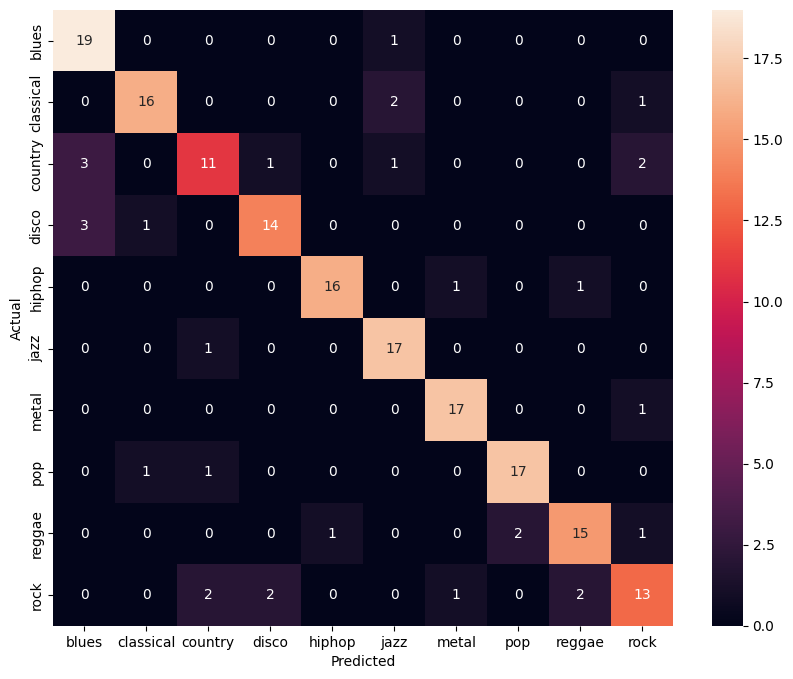

In [204]:
import seaborn as sns
from sklearn.metrics import confusion_matrix  # Import confusion_matrix

# Get model predictions
y_pred_enc = model.predict(x_test).argmax(axis=1)  # Predictions as encoded labels
y_true_enc = y_test_enc  # Use the existing encoded true labels

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_enc, y_pred_enc)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [205]:
model.save("genre_classification_model.keras")